
# MT: 3D: Forward

Forward model 3D MT data.

Test script to use simpeg.NSEM platform to forward model
impedance and tipper synthetic data.


c:\Users\torre\anaconda3\envs\modeling\Lib\site-packages\simpeg\base\pde_simulation.py:490: DefaultSolverWarning: Using the default solver: Pardiso. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)


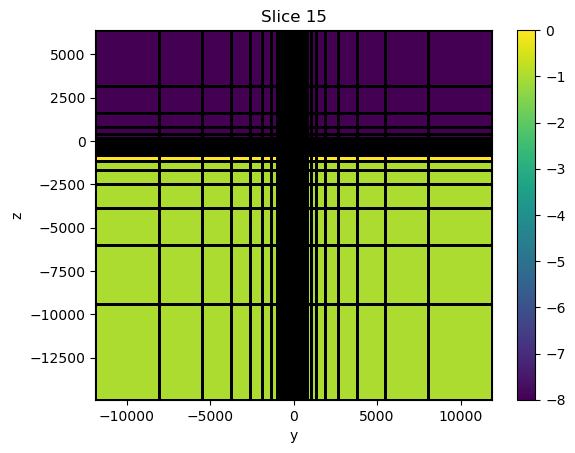

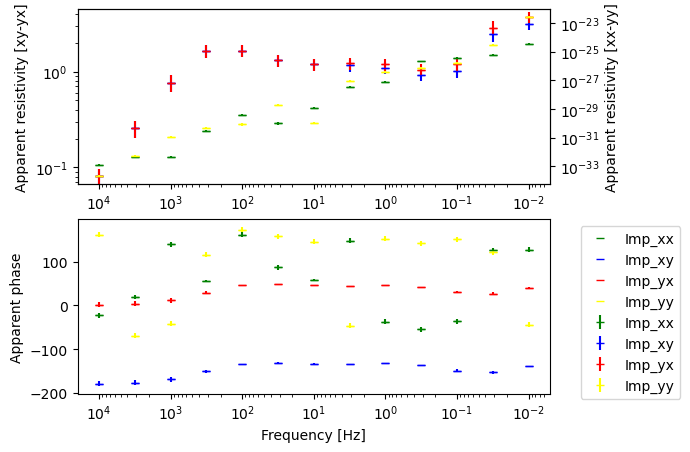

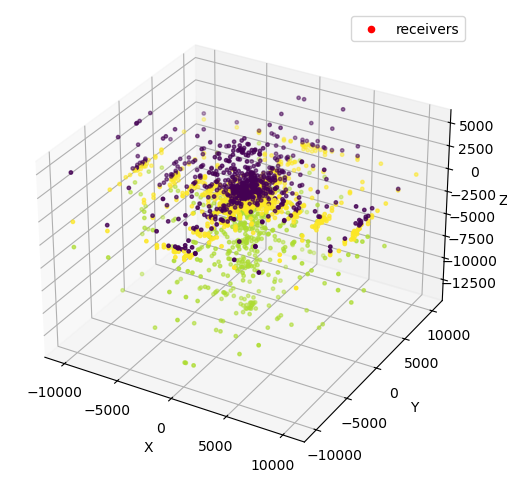

In [1]:
import discretize
from simpeg.electromagnetics import natural_source as NSEM
#from simpeg.electromagnetics.natural_source import receivers as Rx
from simpeg import utils
import numpy as np
import matplotlib.pyplot as plt
import simpeg
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
def run(plotIt=True):
    """
    MT: 3D: Forward
    ===============

    Forward model 3D MT data.

    """

    # Make a mesh
    M = discretize.TensorMesh(
        [
            [(100, 9, -1.5), (100.0, 13), (100, 9, 1.5)],
            [(100, 9, -1.5), (100.0, 13), (100, 9, 1.5)],
            [(50, 10, -1.6), (50.0, 10), (50, 6, 2)],
        ],
        x0=["C", "C", -14926.8217],
    )
    # Setup the model
    conds = [1, 1e-2]
    sig = utils.model_builder.create_block_in_wholespace(
        M.gridCC, [-100, -100, -350], [100, 100, -150], conds
    )
    sig[M.gridCC[:, 2] > 0] = 1e-8
    sig[M.gridCC[:, 2] < -1000] = 1e-1
    sigBG = np.zeros(M.nC) + conds[1]
    sigBG[M.gridCC[:, 2] > 0] = 1e-8
    if plotIt:
        collect_obj = M.plot_slice(np.log10(sig), grid=True, normal="X")[0]
        plt.colorbar(collect_obj)

    # Setup the the survey object
    # Receiver locations
    rx_x, rx_y = np.meshgrid(np.arange(-600, 601, 100), np.arange(-600, 601, 100))
    rx_loc = np.hstack(
        (utils.mkvc(rx_x, 2), utils.mkvc(rx_y, 2), np.zeros((np.prod(rx_x.shape), 1)))
    )

    # Make a receiver list
    receiver_list = []
    for rx_orientation in ["xx", "xy", "yx", "yy"]:
        receiver_list.append(
            simpeg.electromagnetics.natural_source.receivers.Impedance(rx_loc, orientation=rx_orientation, component="real")
        )
        receiver_list.append(
            simpeg.electromagnetics.natural_source.receivers.Impedance(rx_loc, orientation=rx_orientation, component="imag")
        )
    for rx_orientation in ["zx", "zy"]:
        receiver_list.append(
            simpeg.electromagnetics.natural_source.receivers.Tipper(rx_loc, orientation=rx_orientation, component="real")
        )
        receiver_list.append(
            simpeg.electromagnetics.natural_source.receivers.Tipper(rx_loc, orientation=rx_orientation, component="imag")
        )

    # Source list
    source_list = [
        NSEM.Src.PlanewaveXYPrimary(receiver_list, freq)
        for freq in np.logspace(4, -2, 13)
    ]
    # Survey MT
    survey = NSEM.Survey(source_list)

    # Setup the problem object
    problem = NSEM.Simulation3DPrimarySecondary(
        M,
        survey=survey,
        sigma=sig,
        sigmaPrimary=sigBG,
        forward_only=True,
    )

    # Calculate the data
    # data = problem.make_synthetic_data(relative_error=0.1, add_noise=True)
    data = NSEM.Data(survey=survey, dobs=problem.dpred())
    # Add standard deviation to the data - 10% relative error and 0 floor
    data.relative_error = 0.1
    data.noise_floor = 0.0

    # Add plots
    if plotIt:
        # Plot the data
        # On and off diagonal (on left and right axis, respectively)
        fig, axes = plt.subplots(2, 1, figsize=(7, 5))
        plt.subplots_adjust(right=0.8)
        [(ax.invert_xaxis(), ax.set_xscale("log")) for ax in axes]
        ax_r, ax_p = axes
        ax_r.set_yscale("log")
        ax_r.set_ylabel("Apparent resistivity [xy-yx]")
        ax_r_on = ax_r.twinx()
        ax_r_on.set_yscale("log")
        ax_r_on.set_ylabel("Apparent resistivity [xx-yy]")
        ax_p.set_ylabel("Apparent phase")
        ax_p.set_xlabel("Frequency [Hz]")
        # Start plotting
        ax_r = data.plot_app_res(
            np.array([-200, 0]), components=["xy", "yx"], ax=ax_r, errorbars=True
        )
        ax_r_on = data.plot_app_res(
            np.array([-200, 0]), components=["xx", "yy"], ax=ax_r_on, errorbars=True
        )
        ax_p = data.plot_app_phs(
            np.array([-200, 0]),
            components=["xx", "xy", "yx", "yy"],
            ax=ax_p,
            errorbars=True,
        )
        ax_p.legend(bbox_to_anchor=(1.05, 1), loc=2)


# block extents used in your code:
    block_min = np.array([-100, -100, -350])
    block_max = np.array([100,  100, -150])

    # corners of the box
    x0, y0, z0 = block_min
    x1, y1, z1 = block_max
    vertices = np.array([
        [x0,y0,z0], [x1,y0,z0], [x1,y1,z0], [x0,y1,z0],  # bottom face (z0)
        [x0,y0,z1], [x1,y0,z1], [x1,y1,z1], [x0,y1,z1],  # top face (z1)
    ])

    faces = [
        [0,1,2,3],  # bottom
        [4,5,6,7],  # top
        [0,1,5,4],  # front
        [2,3,7,6],  # back
        [1,2,6,5],  # right
        [0,3,7,4],  # left
    ]

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    # translucent faces
    poly = Poly3DCollection([vertices[f] for f in faces], alpha=0.25)
    poly.set_edgecolor('k')
    ax.add_collection3d(poly)

    # plot receiver locations (rx_loc from your code)
    ax.scatter(rx_loc[:,0], rx_loc[:,1], rx_loc[:,2], c='r', s=20, label='receivers')

    # also plot cell centers colored by log sigma (sample a subset if too many)
    cc = M.gridCC
    vals = np.log10(sig)
    subset = np.random.choice(np.arange(M.nC), size=min(2000, M.nC), replace=False)
    ax.scatter(cc[subset,0], cc[subset,1], cc[subset,2], c=vals[subset], cmap='viridis', s=6)

    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_xlim(M.x0[0], M.x0[0] + M.h[0].sum())
    ax.set_ylim(M.x0[1], M.x0[1] + M.h[1].sum())
    ax.set_zlim(M.x0[2], M.x0[2] + M.h[2].sum())
    plt.legend()
    plt.show()


if __name__ == "__main__":
    do_plots = True
    run(do_plots)
    if do_plots:
        plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # only for 3D examples later
import discretize
from simpeg import utils

# assume M, sig, sigBG, rx_loc are already defined (as in your script)

# 3 orthogonal slices through the center of the model
cc = M.gridCC
center_idx = np.argmin(np.linalg.norm(cc - np.mean(cc, axis=0), axis=1))
cx, cy, cz = cc[center_idx]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
normals = ["X", "Y", "Z"]
for ax, normal in zip(axes, normals):
    coll = M.plot_slice(np.log10(sig), normal=normal, grid=True, ax=ax, clim=[-6, 0])
    ax.set_title(f"Slice normal={normal}")
    # plot receiver locations on the slice (project to slice plane)
    if normal == "X":
        ax.scatter(rx_loc[:,1], rx_loc[:,2], s=10, c='k', marker='o', label='receivers')
        ax.set_xlabel('Y'); ax.set_ylabel('Z')
    elif normal == "Y":
        ax.scatter(rx_loc[:,0], rx_loc[:,2], s=10, c='k', marker='o')
        ax.set_xlabel('X'); ax.set_ylabel('Z')
    else:  # Z slice
        ax.scatter(rx_loc[:,0], rx_loc[:,1], s=10, c='k', marker='o')
        ax.set_xlabel('X'); ax.set_ylabel('Y')

# colorbar
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
plt.colorbar(coll, cax=cax, label='log10(sigma) [S/m]')
plt.tight_layout(rect=[0, 0, 0.9, 1.0])
plt.show()


NameError: name 'M' is not defined

NameError: name 'rx_loc' is not defined

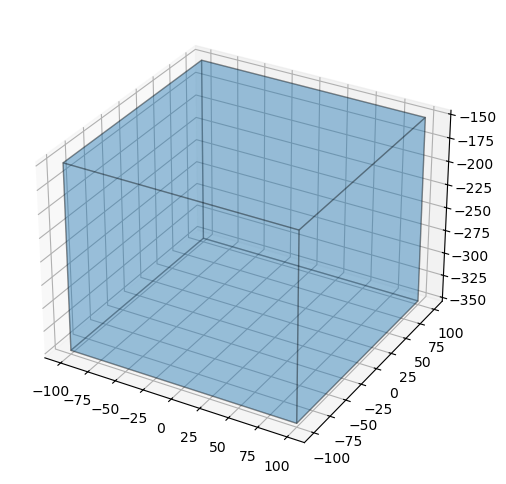